<a href="https://colab.research.google.com/github/prabhakarandata/PowerPulse_-Household-Energy-Usage-Forecast/blob/main/4_V5_Project_PowerPulse_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Block 1 – Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Block 2 – Load Dataset

In [ ]:
# Load dataset
file_path = "/content/drive/MyDrive/S3/household_power_consumption.txt"
data = pd.read_csv(
    file_path,
    sep=";",
    low_memory=False
)

print("Shape:", data.shape)
print("Columns:", data.columns.tolist())


Shape: (1631716, 9)
Columns: ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


# Block 3 – Parse Date & Time

In [ ]:
# Combine Date and Time into DateTime
data["DateTime"] = pd.to_datetime(
    data["Date"] + " " + data["Time"],
    format="%d/%m/%Y %H:%M:%S",
    errors="coerce"
)

# Drop invalid datetime rows
data = data.dropna(subset=["DateTime"])
print("Dropped invalid DateTime rows.")


Dropped invalid DateTime rows.


# Block 4 – Handle Missing Values

In [ ]:
# Replace missing values "?" with NaN
data = data.replace("?", np.nan)

# Convert all except Date, Time, DateTime to numeric
for col in data.columns:
    if col not in ["Date", "Time", "DateTime"]:
        data[col] = pd.to_numeric(data[col], errors="coerce")

# Check missing counts
print("Missing counts before imputation:\n", data.isna().sum())

# Forward fill missing values
data = data.fillna(method="ffill")

print("Missing counts after imputation:\n", data.isna().sum())


Missing counts before imputation:
 Date                         0
Time                         0
Global_active_power      11480
Global_reactive_power    11481
Voltage                  11481
Global_intensity         11481
Sub_metering_1           11481
Sub_metering_2           11481
Sub_metering_3           11481
DateTime                     0
dtype: int64


/tmp/ipython-input-3811012867.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")


Missing counts after imputation:
 Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
DateTime                 0
dtype: int64


# Block 5 – Set Index



In [ ]:
# Set DateTime as index
data = data.set_index("DateTime")
print("Index set to DateTime")


Index set to DateTime


# Block 6 – Resample Data

In [ ]:
# # Resample per hour (mean)
# hourly_data = data.resample("H").mean()
# print("Hourly data shape:", hourly_data.shape)

# Block 6 - Resample Data

# Keep only numeric columns for resampling
numeric_cols = data.select_dtypes(include=[np.number]).columns
numeric_data = data[numeric_cols]

# Resample per hour (mean)
hourly_data = numeric_data.resample("h").mean()

print("Hourly data shape:", hourly_data.shape)
print("Columns after resampling:", hourly_data.columns.tolist())


Hourly data shape: (27196, 7)
Columns after resampling: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


# Block 7 – Plot Global Active Power

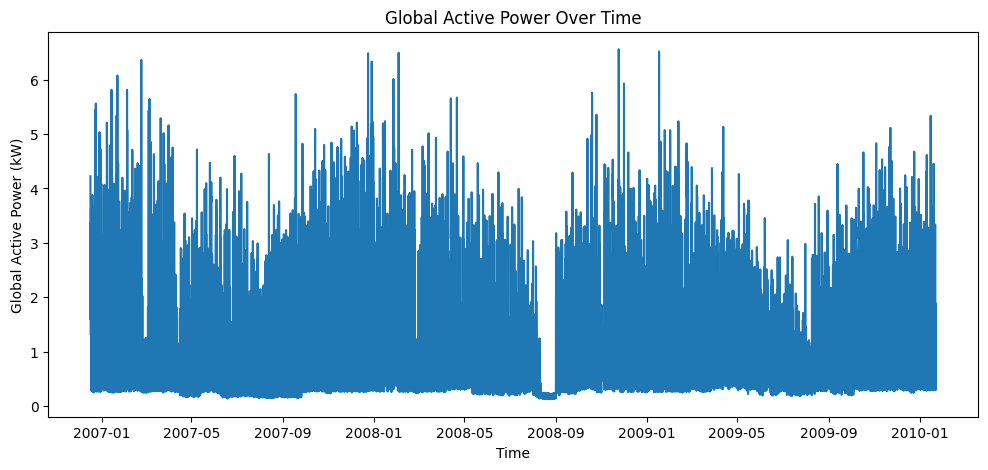

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(hourly_data.index, hourly_data["Global_active_power"])
plt.title("Global Active Power Over Time")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.show()


# Block 8 – Plot Voltage

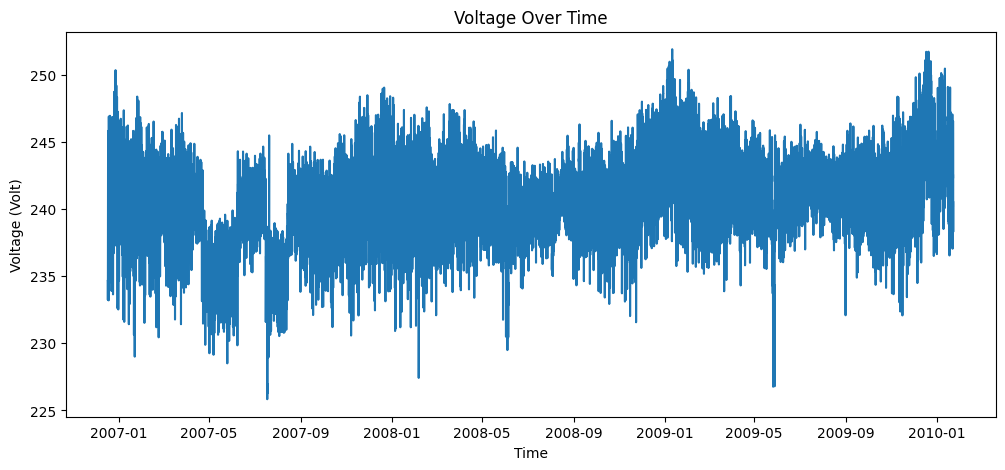

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(hourly_data.index, hourly_data["Voltage"])
plt.title("Voltage Over Time")
plt.xlabel("Time")
plt.ylabel("Voltage (Volt)")
plt.show()


# Block 9 – Plot Sub Metering

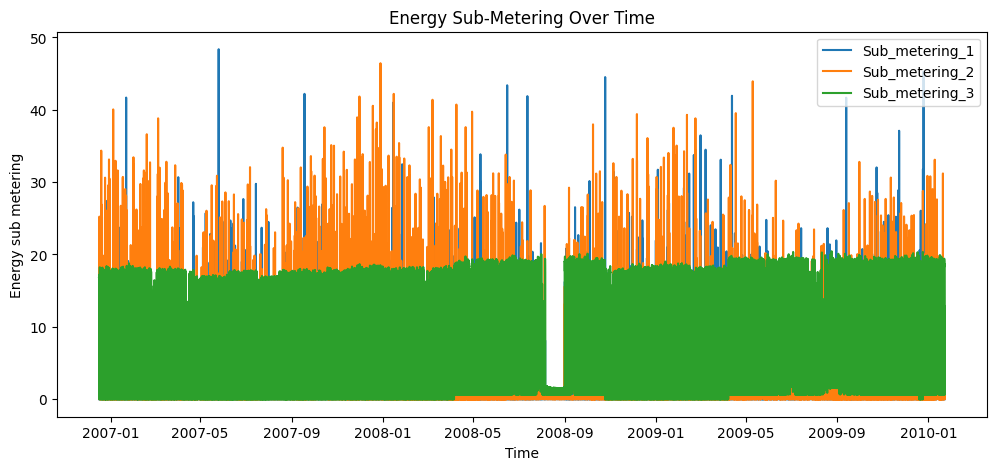

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(hourly_data.index, hourly_data["Sub_metering_1"], label="Sub_metering_1")
plt.plot(hourly_data.index, hourly_data["Sub_metering_2"], label="Sub_metering_2")
plt.plot(hourly_data.index, hourly_data["Sub_metering_3"], label="Sub_metering_3")
plt.title("Energy Sub-Metering Over Time")
plt.xlabel("Time")
plt.ylabel("Energy sub metering")
plt.legend()
plt.show()


# `Block 10` – Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Features (X) and target (y)
X = hourly_data.drop("Global_active_power", axis=1)
y = hourly_data["Global_active_power"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (21756, 6) Test shape: (5440, 6)


# Block 10* – Modeling (Linear Regression, RandomForest, GradientBoosting)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = preds
    print(f"{name} trained successfully.")


Linear Regression trained successfully.
Random Forest trained successfully.
Gradient Boosting trained successfully.


# Block 11 – Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

for name, preds in results.items():
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


Linear Regression → RMSE: 0.0196, MAE: 0.0146, R²: 0.9994
Random Forest → RMSE: 0.0189, MAE: 0.0129, R²: 0.9995
Gradient Boosting → RMSE: 0.0188, MAE: 0.0139, R²: 0.9995


# Block 12 – Visualization of Predictions

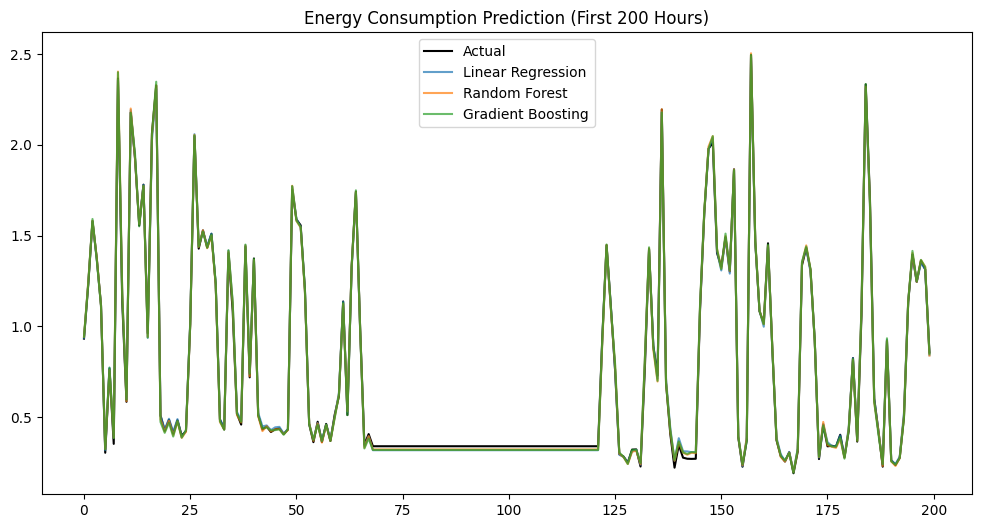

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.values[:200], label="Actual", color="black")
plt.plot
3
 (results["Linear Regression"][:200], label="Linear Regression", alpha=0.7)
plt.plot(results["Random Forest"][:200], label="Random Forest", alpha=0.7)
plt.plot(results["Gradient Boosting"][:200], label="Gradient Boosting", alpha=0.7)
plt.legend()
plt.title("Energy Consumption Prediction (First 200 Hours)")
plt.show()
